# Blockchain: Smart-Contract Vulnerabilities 
Lorenzo Orsini and Gianluca Di Tuccio<br>

The goal of this project is to correctly identify vulnerabilities in Ethereum smart contracts. This is a multi-label classification task with six different vulnerabilities, using three different models: a baseline model using LSTM (as proposed by previous projects), one using two layers of Self-Attention and one with a small Self-Attention for each label, using different branches (similar to ESCORT). The input used was the bytecodes of the contracts, creating a dictionary for the 256 instructions present (each bytecode is identified by two hexadecimal values, i.e., one Byte or Opcode, that in our case is a token).
Furthermore, due to limited hardware resources, the maximum input for the model was chosen to be 512 tokens or bytecodes (i.e., 1024 nibbles). An additional step of this project is to test different opcode windows, such as the initial, final, and middle windows, to verify if the most important information regarding vulnerabilities is located at the beginning, end, or in the middle of the sequence. Additionally, this step aims to verify if there is a correlation between a vulnerability and its position in the sequence.
Obviously, due to limited hardware resources, we were not able to complete proper fine-tuning and only tested a few combinations. Therefore, it is possible to improve these performances by conducting a more accurate fine-tuning. Additionally, a potential future step could be to test a larger input size for self-attention, which has demonstrated better performance than BiLSTM.
Besides, another important step is to tested the models with many different seeds and taking the mean of the f1s between the seeds.

Starting points:
- M. Rossini, M. Zichichi, S. Ferretti, "On the Use of Deep Neural Networks for Security Vulnerabilities Detection in Smart Contracts", in Proc. of the 4th Workshop on Blockchain theoRy and ApplicatIoNs (BRAIN 2023) - 21st International Conference on Pervasive Computing and Communications (PerCom 2023), IEEE, March 2023, Atlanta, USA. Here, self-attention model wasn’t explored and for BiLSTM they tested only the first window (i.e. the first 512 bytecodes);
- Lutz, Oliver, et al. "ESCORT: ethereum smart contracts vulnerability detection using deep neural network and transfer learning." arXiv preprint arXiv:2103.12607 (2021). From here, we take the idea of "branches" for the vulnerabilities, even if their multi-labels dataset had different vulnerabilities.

In [1]:
%%capture
!pip install datasets[vision]
!pip install hexbytes
!pip install transformers
!pip install dataset
!pip install pynvml
!pip install torchsummary

## 1. Import of the libraries and Pip install

In [2]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import random
import numpy as np
from transformers import PreTrainedTokenizer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from utils.util import *
from datasets import Dataset
from sklearn.metrics import classification_report
device = torch.device("cuda:1")
torch.cuda.set_device(device)

## 2. Load of the Dataset

In [3]:
tokens = 256 # number of opcodes that we use in the notebook

df = pd.read_csv('train_actual.csv')
df = shuffle(df, random_state=seed)
df_val = pd.read_csv('val_actual.csv')
df_test = pd.read_csv('test_actual.csv')

## 3. Tokenizer

In [4]:
# create the dict from 00 to FF (even if not all the bytecodes will be used)
hex_dict = {i: f"{j:02x}".upper() for i, j in enumerate(range(256))}
hex_dict[256] = '<UNK>'
hex_dict[257] = '<PAD>'
hex_dict[258] = '<INIT>'
hex_dict[259] = '<END>'


class HexTokenizer(PreTrainedTokenizer):
    def __init__(self, hex_dict, max_length=None):
        self.hex_dict = hex_dict
        self.ids_to_tokens = {i: hex_dict[i] for i in range(len(hex_dict))}
        self.tokens_to_ids = {v: k for k, v in self.ids_to_tokens.items()}
        self.max_length = max_length
        tokenizer_kwargs = {"vocab_size": len(hex_dict)}
        super().__init__(**tokenizer_kwargs)

        
    def encode(self, text):
        
        # truncate the input with the maximum length
        if self.max_length is not None and len(text) > self.max_length:
            text = text[:self.max_length]
        
        
        # convert pair of nibbles in a token
        ids = []
        for i in range(0, len(text), 2):
            code = text[i:i+2]
            if code == '0X':
                ids.append(self.tokens_to_ids["<INIT>"])
            elif code in self.tokens_to_ids:
                ids.append(self.tokens_to_ids[code])
            else:
                # if the byte isn't in the vocabulary
                ids.append(self.tokens_to_ids["<UNK>"])
        
        # add padding
        for i in range(self.max_length//2 - len(ids)):
            ids.append(self.tokens_to_ids["<PAD>"])
            
        # replace the last token with the end token
        ids[-1] = self.tokens_to_ids["<END>"]
        return ids

    def decode(self, ids):
        text = ''.join([self.ids_to_tokens[i] for i in ids])
        return text

tokenizer = HexTokenizer(hex_dict, tokens)

In [5]:
# convert the string in a list of tokens
# (due to the computational issue, we saved all the previous tokens and bytecodes in a csv using Colab)
input_batch = df['tokenized']
input_lists = []
for input_str in input_batch:
    input_list = [int(x) for x in input_str.strip('[]').split(', ')]
    input_list = input_list.copy()[:tokens-1]
    input_list.append(259)
    input_list[0] = 258
    input_lists.append(input_list)
df['tokenized'] = input_lists

input_batch = df_val['tokenized']
input_lists = []
for input_str in input_batch:
    input_list = [int(x) for x in input_str.strip('[]').split(', ')]
    input_list = input_list.copy()[:tokens-1]
    input_list.append(259)
    input_list[0] = 258
    input_lists.append(input_list)
df_val['tokenized'] = input_lists

input_batch = df_test['tokenized']
input_lists = []
for input_str in input_batch:
    input_list = [int(x) for x in input_str.strip('[]').split(', ')]
    input_list = input_list.copy()[:tokens-1]
    input_list.append(259)
    input_list[0] = 258
    input_lists.append(input_list)
df_test['tokenized'] = input_lists

In [6]:
len(df_test['tokenized'][0])

256

## 4. One Hot Encoding of the Slithers

In [7]:
label_batch = df['slither']
label_lists = []
for label_str in label_batch:
    label_list = [int(x) for x in label_str.strip('[]').split(', ')]
    label_lists.append(label_list)
df['slither'] = label_lists

label_batch = df_val['slither']
label_lists = []
for label_str in label_batch:
    label_list = [int(x) for x in label_str.strip('[]').split(', ')]
    label_lists.append(label_list)
df_val['slither'] = label_lists

label_batch = df_test['slither']
label_lists = []
for label_str in label_batch:
    label_list = [int(x) for x in label_str.strip('[]').split(', ')]
    label_lists.append(label_list)
df_test['slither'] = label_lists

## 5. From Pandas to Torch Dataset 

In [8]:
train = Dataset.from_pandas(df)
train.set_format(type="torch")

val = Dataset.from_pandas(df_val)
val.set_format(type="torch")

test = Dataset.from_pandas(df_test)
test.set_format(type="torch")

## 6. LSTM 

In [9]:
size = tokens//2

# EMBEDDING with size=tokens/2 --> BiLSTM with 3 Layers --> Classification Head
class Modified_LSTM(nn.Module):
    def __init__(self, num_labels=6):
        super().__init__()
        self.embedding = nn.Embedding(len(hex_dict), size, padding_idx=257)
        self.lstm = nn.LSTM(bidirectional=True, input_size=size, hidden_size=size//2, batch_first=True, num_layers=3)
        
        self.classifier = nn.Sequential(
            nn.Linear(size, size*2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(size*2, num_labels)
        )

    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        
        embedded_tokens = self.embedding(input_ids)
        
        _, (h_0, _) = self.lstm(embedded_tokens)
        last_hidden = torch.cat([h_0[-2,:,:], h_0[-1,:,:]], dim=1)

        logits = self.classifier(last_hidden)

        return torch.sigmoid(logits)

model = Modified_LSTM()
model.to('cuda')
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")
model

Number of parameters: 365830


Modified_LSTM(
  (embedding): Embedding(260, 128, padding_idx=257)
  (lstm): LSTM(128, 64, num_layers=3, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [10]:
max_lr = 0.001
batch_size = 128 
num_epochs = 3 # due to hardware limitations

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr)
losses = []
val_losses = []

for epoch in range(num_epochs):
    
    # TRAIN PHASE
    epoch_loss = 0
    epoch_f1 = 0
    model.train()
    for i in tqdm(range(0, len(train), batch_size)):
        input_batch = train['tokenized'][i:i+batch_size].to('cuda')
        label_batch = train['slither'][i:i+batch_size].to('cuda')
        
        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # F1
        y_true = label_batch.cpu().numpy()
        y_pred = (outputs > 0.5).cpu().numpy() # here we used a threshold of 0.5 for detecting if the vulnerabilities
        batch_f1 = f1_multi_label_score(y_true, y_pred)
        epoch_f1 += batch_f1 * batch_size
    losses.append(epoch_loss/len(train))
    print(f"TRAIN: Epoch {epoch+1} loss: {epoch_loss/len(train):.6f}, F1 score: {epoch_f1/len(train):.4f}")
    
    
    # VALIDATION PHASE
    epoch_loss = 0
    epoch_f1 = 0
    model.eval()
    for i in range(0, len(val), batch_size):
        input_batch = val['tokenized'][i:i+batch_size].to('cuda')
        label_batch = val['slither'][i:i+batch_size].to('cuda')
        
        outputs = model(input_batch)
        loss = criterion(outputs, label_batch.float())
        epoch_loss += loss.item()
        
        # F1
        y_true = label_batch.cpu().numpy()
        y_pred = (outputs > 0.5).cpu().numpy()
        batch_f1 = f1_multi_label_score(y_true, y_pred)
        epoch_f1 += batch_f1 * batch_size
    val_losses.append(epoch_loss/len(val))
    print(f"VAL: Epoch {epoch+1} loss: {epoch_loss/len(val):.6f}, F1 score: {epoch_f1/len(val):.4f}")

100%|██████████| 623/623 [02:59<00:00,  3.47it/s]


TRAIN: Epoch 1 loss: 0.003303, F1 score: 0.5352
VAL: Epoch 1 loss: 0.002845, F1 score: 0.6160


100%|██████████| 623/623 [02:59<00:00,  3.47it/s]


TRAIN: Epoch 2 loss: 0.002646, F1 score: 0.6680
VAL: Epoch 2 loss: 0.002503, F1 score: 0.6778


100%|██████████| 623/623 [02:58<00:00,  3.48it/s]


TRAIN: Epoch 3 loss: 0.002393, F1 score: 0.7035
VAL: Epoch 3 loss: 0.002327, F1 score: 0.7167


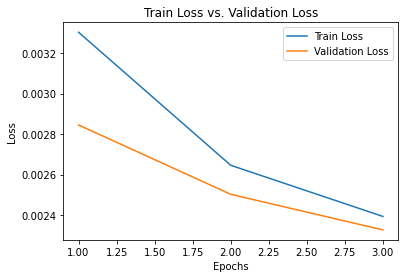

In [11]:
# as we can see below, we don't have any overfitting
x = range(1, len(losses) + 1)
plt.plot(x, losses, label='Train Loss')
plt.plot(x, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Validation Loss')
plt.legend()
plt.show()

Before testing the model with the test set, we iterate along the validation set for finding the optimal threhsold. Then, we use this threshold in the test set.

In [12]:
model.eval()
results_f1 = []
batches = 512

# Iterate the threshold on VAL
thresholds = [x / 100 for x in range(30, 51, 5)]
for j in tqdm(thresholds):
    f1s = 0
    for i in range(0, len(val), batches):   
        input_batch = val['tokenized'][i:i+batch_size].to('cuda')
        label_batch = val['slither'][i:i+batch_size].to('cuda')

        outputs = model(input_batch)
        f1s += f1_multi_label_score(label_batch.cpu().numpy(), (outputs > j).cpu().numpy())*batches
    results_f1.append(f1s/len(val))

maximum = max(results_f1)
print(f'Best Thresh: {thresholds[results_f1.index(maximum)]}, micro f1 score: {round(maximum,3)}')

100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

Best Thresh: 0.35, micro f1 score: 0.754


In [13]:
# Test SET
f1s = 0
for i in range(0, len(test), batches):   
    input_batch = test['tokenized'][i:i+batch_size].to('cuda')
    label_batch = test['slither'][i:i+batch_size].to('cuda')

    outputs = model(input_batch)
    f1s += f1_multi_label_score(label_batch.cpu().numpy(), (outputs > thresholds[results_f1.index(maximum)]).cpu().numpy())*batches
print(f'Micro f1 score on test set: {round(f1s/len(test),3)}')

Micro f1 score on test set: 0.749


## 7. Self-Attention

In [14]:
size = tokens
    
# EMBEDDING with size=tokens --> MHA with 4 heads --> MHA with 4 heads --> Classification Head
class ModifiedTransformerModel(nn.Module):
    def __init__(self, num_labels=6):
        super().__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding(len(hex_dict), size, padding_idx=257)
        self.attention = nn.MultiheadAttention(embed_dim=size, num_heads=4, batch_first=True)
        self.attention2 = nn.MultiheadAttention(embed_dim=size, num_heads=4, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(size, size*2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(size*2, num_labels)
        )

    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        embedded_tokens = []
        for i in range(sequence_length):
            embedded = self.embedding(input_ids[:, i])
            embedded_tokens.append(embedded)
        embedded_input = torch.stack(embedded_tokens, dim=1)

        embedded_input = embedded_input.permute(1, 0, 2)
        attention_output, _ = self.attention(embedded_input, embedded_input, embedded_input)
        attention_output = attention_output.permute(1, 0, 2)
        attention_output2, _ = self.attention2(attention_output, attention_output, attention_output)
        
        pooled_output = torch.mean(attention_output2, dim=1)       

        logits = self.classifier(pooled_output)   

        return torch.sigmoid(logits)

model = ModifiedTransformerModel()
model.to('cuda')
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")
model

Number of parameters: 727558


ModifiedTransformerModel(
  (embedding): Embedding(260, 256, padding_idx=257)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (attention2): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [15]:
max_lr = 0.001
batch_size = 128
num_epochs = 3 # due to hardware limitations

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr)
losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_f1 = 0
    model.train()
    for i in tqdm(range(0, len(train), batch_size)):
        input_batch = train['tokenized'][i:i+batch_size].to('cuda')
        label_batch = train['slither'][i:i+batch_size].to('cuda')
        
        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # F1
        y_true = label_batch.cpu().numpy()
        y_pred = (outputs > 0.5).cpu().numpy()
        batch_f1 = f1_multi_label_score(y_true, y_pred)
        epoch_f1 += batch_f1 * batch_size
    losses.append(epoch_loss/len(train))
    print(f"TRAIN: Epoch {epoch+1} loss: {epoch_loss/len(train):.6f}, F1 score: {epoch_f1/len(train):.4f}")
    
    
    # VALIDATION
    epoch_loss = 0
    epoch_f1 = 0
    model.eval()
    for i in range(0, len(val), batch_size):
        input_batch = val['tokenized'][i:i+batch_size].to('cuda')
        label_batch = val['slither'][i:i+batch_size].to('cuda')
        
        outputs = model(input_batch)
        loss = criterion(outputs, label_batch.float())
        epoch_loss += loss.item()
        
        # F1
        y_true = label_batch.cpu().numpy()
        y_pred = (outputs > 0.5).cpu().numpy()
        batch_f1 = f1_multi_label_score(y_true, y_pred)
        epoch_f1 += batch_f1 * batch_size
    val_losses.append(epoch_loss/len(val))
    print(f"VAL: Epoch {epoch+1} loss: {epoch_loss/len(val):.6f}, F1 score: {epoch_f1/len(val):.4f}")

100%|██████████| 623/623 [03:18<00:00,  3.13it/s]


TRAIN: Epoch 1 loss: 0.003114, F1 score: 0.6235
VAL: Epoch 1 loss: 0.002766, F1 score: 0.6993


100%|██████████| 623/623 [03:15<00:00,  3.19it/s]


TRAIN: Epoch 2 loss: 0.002651, F1 score: 0.7083
VAL: Epoch 2 loss: 0.002560, F1 score: 0.7239


100%|██████████| 623/623 [03:14<00:00,  3.20it/s]


TRAIN: Epoch 3 loss: 0.002538, F1 score: 0.7238
VAL: Epoch 3 loss: 0.002534, F1 score: 0.7288


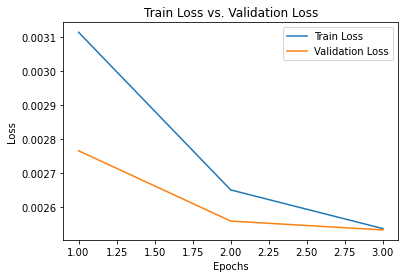

In [16]:
x = range(1, len(losses) + 1)
plt.plot(x, losses, label='Train Loss')
plt.plot(x, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Validation Loss')
plt.legend()
plt.show()

In [17]:
model.eval()
results_f1 = []
batches = 512

thresholds = [x / 100 for x in range(30, 51, 5)]
for j in tqdm(thresholds):
    f1s = 0
    for i in range(0, len(val), batches):   
        input_batch = val['tokenized'][i:i+batch_size].to('cuda')
        label_batch = val['slither'][i:i+batch_size].to('cuda')

        outputs = model(input_batch)
        f1s += f1_multi_label_score(label_batch.cpu().numpy(), (outputs > j).cpu().numpy())*batches
    results_f1.append(f1s/len(val))

maximum = max(results_f1)
print(f'Best Thresh: {thresholds[results_f1.index(maximum)]}, micro f1 score: {round(maximum,3)}')

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]

Best Thresh: 0.35, micro f1 score: 0.773


In [18]:
f1s = 0
for i in range(0, len(test), batches):   
    input_batch = test['tokenized'][i:i+batch_size].to('cuda')
    label_batch = test['slither'][i:i+batch_size].to('cuda')

    outputs = model(input_batch)
    f1s += f1_multi_label_score(label_batch.cpu().numpy(), (outputs > thresholds[results_f1.index(maximum)]).cpu().numpy())*batches
print(f'Micro f1 score on test set: {round(f1s/len(test),3)}')

Micro f1 score on test set: 0.767


## 8. Branch-Self-Attention

In [9]:
size = tokens//2

# EMBEDDING with size=tokens/2 --> MHA for each branch (each branch for each vulnerability) --> Classification Head
class Branch_Self_Attention(nn.Module):
    def __init__(self, num_labels=6):
        super().__init__()
        self.num_labels = num_labels
        self.embedding = nn.Embedding(len(hex_dict), size, padding_idx=257)
        self.attentions = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=size, num_heads=4, batch_first=True)
            for _ in range(self.num_labels)
        ])
        self.classifiers = nn.ModuleList([
            nn.Linear(size, 1)
            for _ in range(self.num_labels)
            ])

    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        embedded_tokens = []
        for i in range(sequence_length):
            embedded = self.embedding(input_ids[:, i])
            embedded_tokens.append(embedded)
        embedded_input = torch.stack(embedded_tokens, dim=1)

        embedded_input = embedded_input.permute(1, 0, 2)
        attention_outputs = []
        for i in range(self.num_labels):
            attention_output, _ = self.attentions[i](embedded_input, embedded_input, embedded_input)
            attention_output = attention_output.permute(1, 0, 2)
            attention_outputs.append(attention_output)

        logits = []
        for i in range(self.num_labels):
            pooled_output = torch.mean(attention_outputs[i], dim=1)
            classifier_output = self.classifiers[i](pooled_output)
            logits.append(classifier_output.squeeze())

        return torch.sigmoid(torch.stack(logits).t())
model = Branch_Self_Attention()
model.to('cuda')
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")
model

Number of parameters: 430342


Branch_Self_Attention(
  (embedding): Embedding(260, 128, padding_idx=257)
  (attentions): ModuleList(
    (0): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (3): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (4): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (5): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
  )
  (classifiers): ModuleList(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Linear(in

In [10]:
max_lr = 0.001
batch_size = 128
num_epochs = 3 # due to hardware limitations

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr)
losses = []
val_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_f1 = 0
    model.train()
    for i in tqdm(range(0, len(train), batch_size)):
        input_batch = train['tokenized'][i:i+batch_size].to('cuda')
        label_batch = train['slither'][i:i+batch_size].to('cuda')
        
        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = criterion(outputs, label_batch.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # F1
        y_true = label_batch.cpu().numpy()
        y_pred = (outputs > 0.5).cpu().numpy()
        batch_f1 = f1_multi_label_score(y_true, y_pred)
        epoch_f1 += batch_f1 * batch_size
    losses.append(epoch_loss/len(train))
    print(f"TRAIN: Epoch {epoch+1} loss: {epoch_loss/len(train):.6f}, F1 score: {epoch_f1/len(train):.4f}")
    
    
    # VALIDATION
    epoch_loss = 0
    epoch_f1 = 0
    model.eval()
    for i in range(0, len(val), batch_size):
        input_batch = val['tokenized'][i:i+batch_size].to('cuda')
        label_batch = val['slither'][i:i+batch_size].to('cuda')
        
        outputs = model(input_batch)
        loss = criterion(outputs, label_batch.float())
        epoch_loss += loss.item()
        
        # F1
        y_true = label_batch.cpu().numpy()
        y_pred = (outputs > 0.5).cpu().numpy()
        batch_f1 = f1_multi_label_score(y_true, y_pred)
        epoch_f1 += batch_f1 * batch_size
    val_losses.append(epoch_loss/len(val))
    print(f"VAL: Epoch {epoch+1} loss: {epoch_loss/len(val):.6f}, F1 score: {epoch_f1/len(val):.4f}")

100%|██████████| 623/623 [02:59<00:00,  3.48it/s]


TRAIN: Epoch 1 loss: 0.003005, F1 score: 0.6589
VAL: Epoch 1 loss: 0.002712, F1 score: 0.7238


100%|██████████| 623/623 [03:00<00:00,  3.46it/s]


TRAIN: Epoch 2 loss: 0.002608, F1 score: 0.7381
VAL: Epoch 2 loss: 0.002591, F1 score: 0.7451


100%|██████████| 623/623 [03:01<00:00,  3.44it/s]


TRAIN: Epoch 3 loss: 0.002501, F1 score: 0.7518
VAL: Epoch 3 loss: 0.002536, F1 score: 0.7548


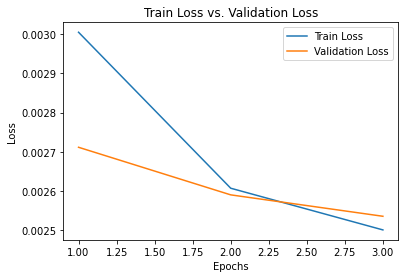

In [11]:
x = range(1, len(losses) + 1)
plt.plot(x, losses, label='Train Loss')
plt.plot(x, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Validation Loss')
plt.legend()
plt.show()

In [12]:
model.eval()
results_f1 = []
batches = 512

thresholds = [x / 100 for x in range(30, 51, 5)]
for j in tqdm(thresholds):
    f1s = 0
    for i in range(0, len(val), batches):   
        input_batch = val['tokenized'][i:i+batch_size].to('cuda')
        label_batch = val['slither'][i:i+batch_size].to('cuda')

        outputs = model(input_batch)
        f1s += f1_multi_label_score(label_batch.cpu().numpy(), (outputs > j).cpu().numpy())*batches
    results_f1.append(f1s/len(val))

maximum = max(results_f1)
print(f'Best Thresh: {thresholds[results_f1.index(maximum)]}, micro f1 score: {round(maximum,3)}')

100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

Best Thresh: 0.4, micro f1 score: 0.786


In [13]:
f1s = 0
for i in range(0, len(test), batches):   
    input_batch = test['tokenized'][i:i+batch_size].to('cuda')
    label_batch = test['slither'][i:i+batch_size].to('cuda')

    outputs = model(input_batch)
    f1s += f1_multi_label_score(label_batch.cpu().numpy(), (outputs > thresholds[results_f1.index(maximum)]).cpu().numpy())*batches
print(f'Micro f1 score on test set: {round(f1s/len(test),3)}')

Micro f1 score on test set: 0.777


## 9. Results
You can find all the considerations on the power point. Besides, all the results have been stored in a csv called 'EXAM.csv'.

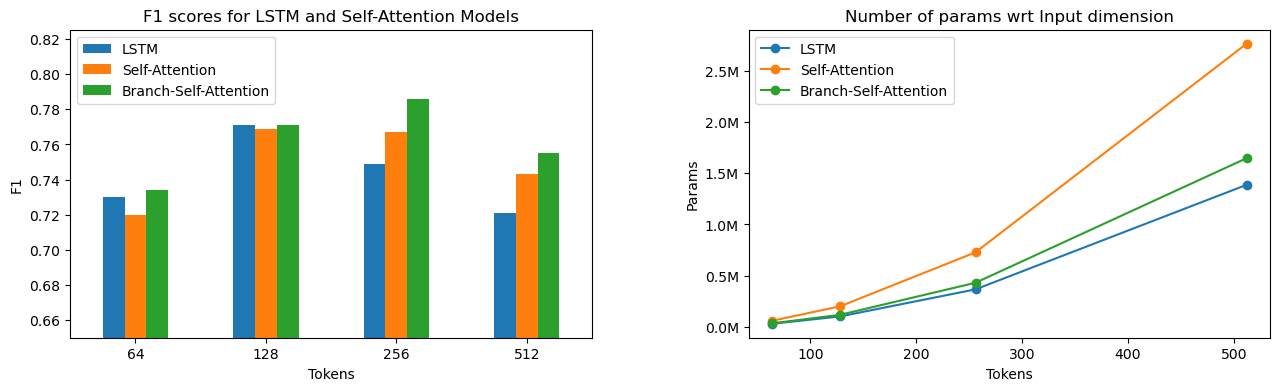

In [6]:
data1 = {
    'LSTM': [0.730, 0.771, 0.749, 0.721],
    'Self-Attention': [0.720, 0.769, 0.767, 0.743],
    'Branch-Self-Attention':[0.734, 0.771, 0.786, 0.755]
}
index = [64, 128, 256, 512]
df1 = pd.DataFrame(data=data1, index=index)
data2 = {
    'LSTM': [30022, 100998, 365830, 1387014],
    'Self-Attention': [59014, 199942, 727558, 2765830],
    'Branch-Self-Attention': [33862, 116870, 430342, 1647110]
}
df2 = pd.DataFrame(data=data2, index=index)
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
df1.plot(kind='bar', rot=0, ax=ax1)
ax1.set_xlabel('Tokens')
ax1.set_ylabel('F1')
ax1.set_title('F1 scores for LSTM and Self-Attention Models')
ax1.set_ylim(bottom=0.65)
ax1.legend(loc='upper left')
df2.plot(kind='line', marker='o', ax=ax2)
ax2.set_xlabel('Tokens')
ax2.set_ylabel('Params')
ax2.set_title('Number of params wrt Input dimension')
ax2.legend(loc='upper left')
fmt = lambda x, pos: '{:.1f}M'.format(x / 1e6)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(fmt))
fig.subplots_adjust(wspace=0.3, left=0.1, right=0.9)
plt.show()

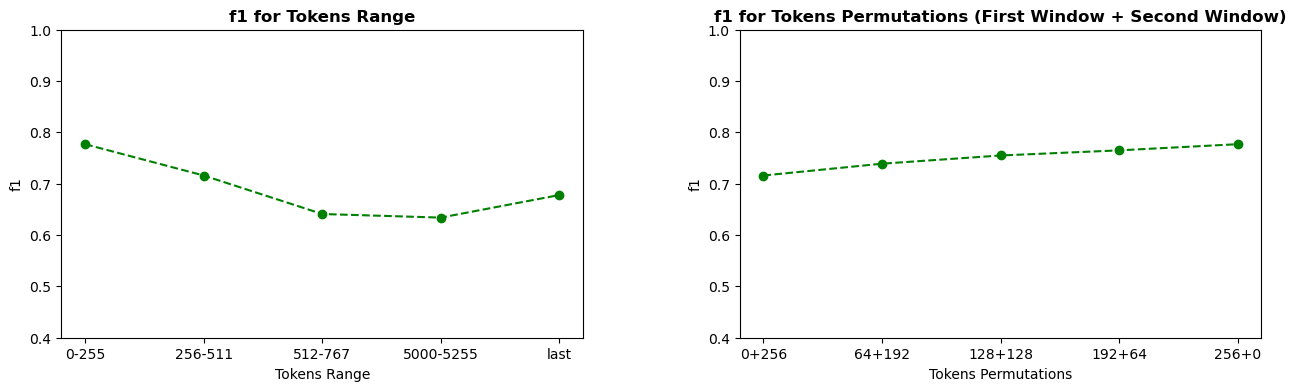

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd

data = pd.read_csv('EXAM.csv').iloc[:5]
data2 = pd.read_csv('EXAM.csv').iloc[5:]

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(data['Range'], data['micro f1'], linestyle='--', marker='o', color='g')
ax1.set_xlabel('Tokens Range')
ax1.set_ylabel('f1')
ax1.set_title('f1 for Tokens Range', fontweight='bold')
ax1.set_ylim(bottom=0.4, top=1)

ax2.plot(data2['Range'], data2['micro f1'], linestyle='--', marker='o', color='g')
ax2.set_xlabel('Tokens Permutations')
ax2.set_ylabel('f1')
ax2.set_title('f1 for Tokens Permutations (First Window + Second Window)', fontweight='bold')
ax2.set_ylim(bottom=0.4, top=1)

fig.subplots_adjust(wspace=0.3, left=0.1, right=0.9)
plt.show()

## 10. F1 for each slither

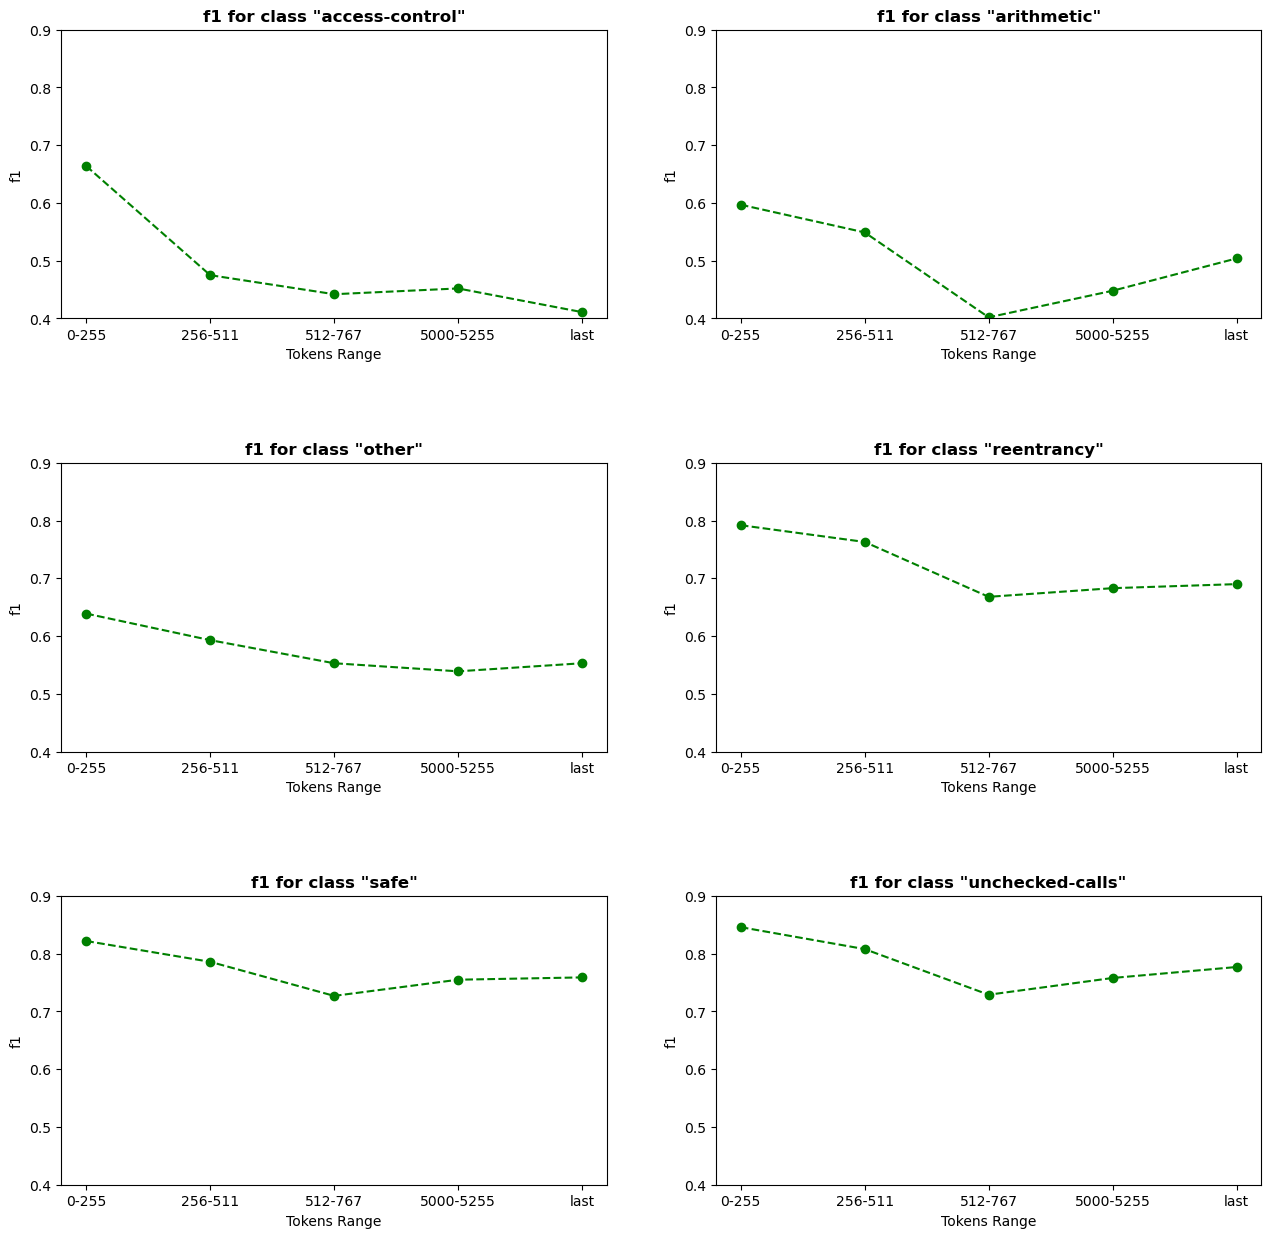

In [24]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)
axis = [ax1, ax2, ax3, ax4, ax5, ax6]
columns = list(data.columns)[1:7]
LABELS = {0:'access-control', 1:'arithmetic', 2:'other', 3:'reentrancy', 4:'safe', 5:'unchecked-calls'}

for i in range(len(axis)):
    axis[i].plot(data['Range'], data[columns[i]], linestyle='--', marker='o', color='g')
    axis[i].set_xlabel('Tokens Range')
    axis[i].set_ylabel('f1')
    axis[i].set_title(f'f1 for class "{LABELS[i]}"', fontweight='bold')
    axis[i].set_ylim(bottom=0.4, top=0.9)

fig.subplots_adjust(hspace=0.5, wspace=0.2, left=0.1, right=0.9)
plt.show()

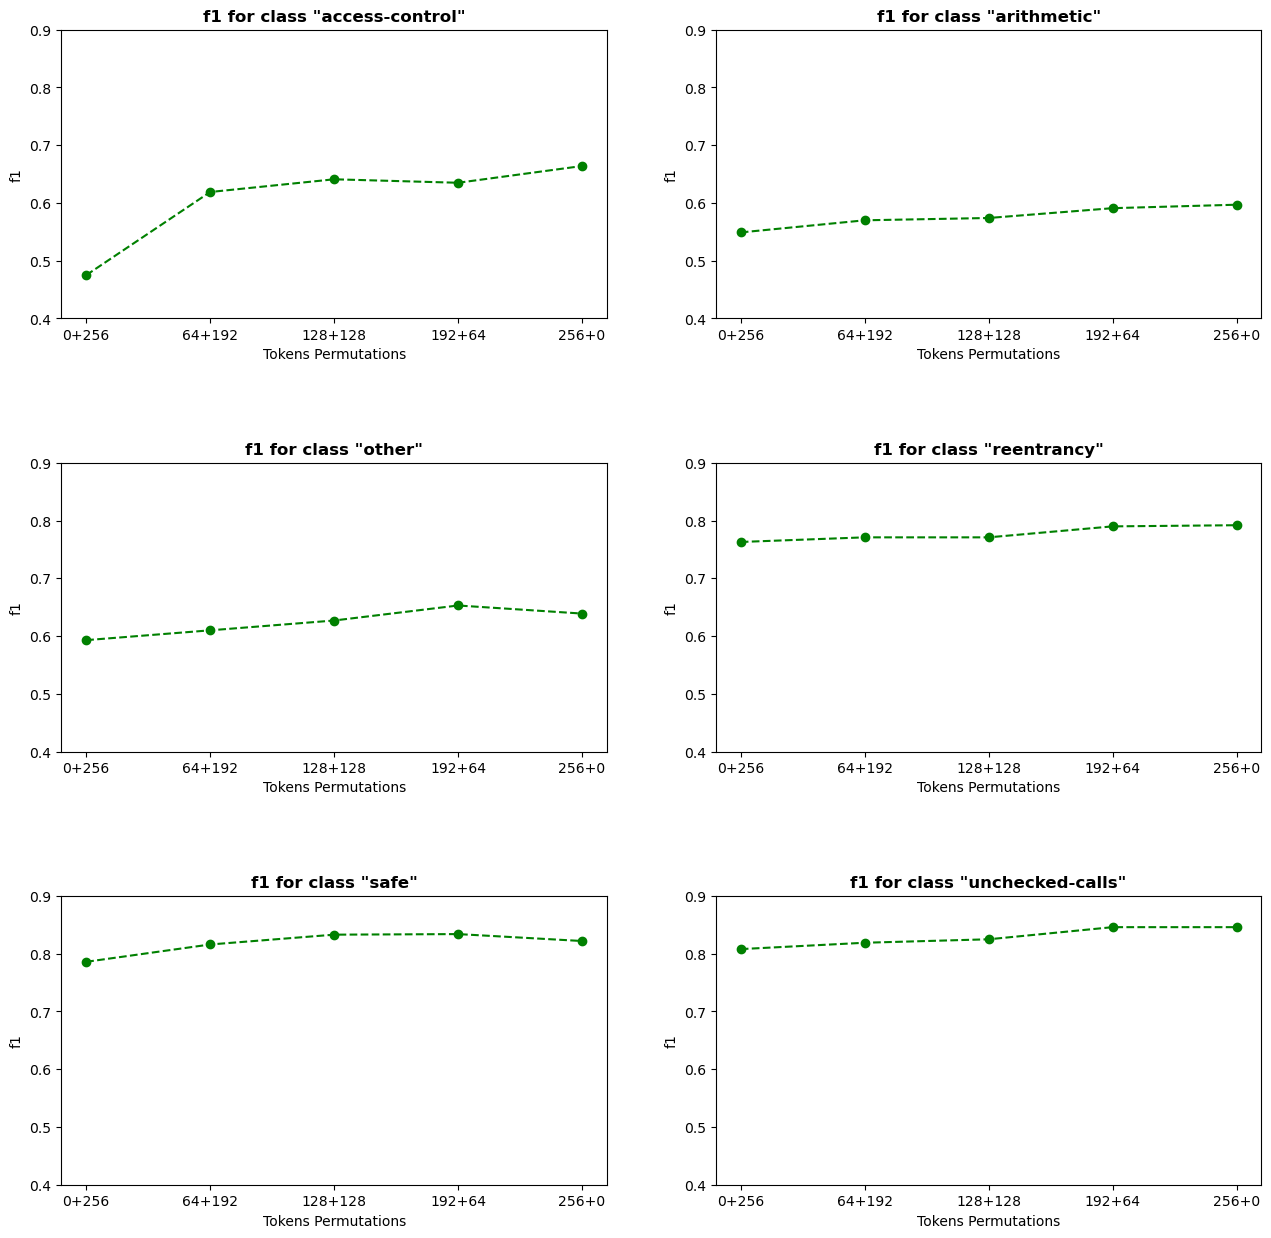

In [23]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)
axis = [ax1, ax2, ax3, ax4, ax5, ax6]
columns = list(data2.columns)[1:7]

for i in range(len(axis)):
    axis[i].plot(data2['Range'], data2[columns[i]], linestyle='--', marker='o', color='g')
    axis[i].set_xlabel('Tokens Permutations')
    axis[i].set_ylabel('f1')
    axis[i].set_title(f'f1 for class "{LABELS[i]}"', fontweight='bold')
    axis[i].set_ylim(bottom=0.4, top=0.9)

fig.subplots_adjust(hspace=0.5, wspace=0.2, left=0.1, right=0.9)
plt.show()